In [28]:
class Player:
    def __init__(self, name, position, offense, defense, stamina, speed, iq, usage):
        self.name = name
        self.position = position
        self.offense = offense
        self.defense = defense
        self.stamina = stamina
        self.speed = speed
        self.iq = iq
        self.usage = usage
        self.confidence = 1.0
        
        self.points = 0
        self.shots_made = 0
        self.shots_attempted = 0
        self.assists = 0

    def adjust_attributes(self, matchup_effect):
        self.offense += matchup_effect['offense']
        self.defense += matchup_effect['defense']

class Team:
    def __init__(self, name, players):
        self.name = name
        self.players = players
        self.strategy = 'balanced'

    def adjust_strategy(self, new_strategy):
        self.strategy = new_strategy


In [29]:
def calculate_matchup_effect(offensive_player, defensive_player):
    offense_effect = offensive_player.offense - defensive_player.defense
    defense_effect = defensive_player.defense - offensive_player.offense
    return {'offense': offense_effect, 'defense': defense_effect}

def apply_matchup_effects(offensive_team, defensive_team):
    for player in offensive_team.players:
        for opponent in defensive_team.players:
            if player.position == opponent.position:
                effect = calculate_matchup_effect(player, opponent)
                player.adjust_attributes(effect)

In [30]:
# Cell 3
import random

def generate_outcomes(players):
    outcomes = []
    for player in players:
        outcomes.extend([
            (f'{player.name} 3pt', player),
            (f'{player.name} Midrange', player),
            (f'{player.name} Inside', player)
        ])
    return outcomes

def get_success_rate(player, outcome):
    if '3pt' in outcome:
        return player.offense
    elif 'Midrange' in outcome:
        return player.offense
    elif 'Inside' in outcome:
        return player.offense
    return 0

def simulate_possession(offensive_team, defensive_team, play_by_play):
    # Generate outcomes dynamically based on the players in the team
    outcomes = generate_outcomes(offensive_team.players)
    
    # Select key decision maker based on usage probability
    decision_maker = random.choices(offensive_team.players, weights=[p.usage for p in offensive_team.players], k=1)[0]
    
    
    # Adjust the weights based on the decision maker's IQ
    outcome_weights = []
    for outcome, player in outcomes:
        success_rate = get_success_rate(player, outcome)
        base_weight = 1  # Each outcome starts with an equal base weight
        if decision_maker.iq > 75:
            weight = base_weight * (1 + success_rate)  # Higher IQ favors more successful outcomes
        else:
            weight = base_weight  # Lower IQ keeps the weight distribution more even
        outcome_weights.append(weight)
    
    selected_outcome, selected_player = random.choices(outcomes, weights=outcome_weights, k=1)[0]
    
    # Success check based on matchup and player attributes
    primary_defender = next(p for p in defensive_team.players if p.position == selected_player.position)
    success_probability = (get_success_rate(selected_player, selected_outcome) / 
                           (get_success_rate(selected_player, selected_outcome) + primary_defender.defense))
    
    result = 'missed'
    selected_player.shots_attempted += 1
    if random.random() < success_probability:
        result = 'made'
        selected_player.shots_made += 1
        decision_maker.assists += 1
        if '3pt' in selected_outcome:
            selected_player.points += 3
        else:
            selected_player.points += 2
    
    # Add to play-by-play
    if (decision_maker == selected_player or result == 'missed'):
        play_by_play.append(f"{selected_outcome} and {result}.")
    elif (result == 'made'):
        play_by_play.append(f"{selected_outcome} and {result} Ast. {decision_maker.name}")
    
    return selected_outcome, result

def simulate_game(team1, team2, possessions):
    team1_score = 0
    team2_score = 0
    play_by_play = []
    
    for i in range(possessions):
        outcome, result = simulate_possession(team1, team2, play_by_play)
        if result == 'made':
            if '3pt' in outcome:
                team1_score += 3
            elif 'Midrange' in outcome or 'Inside' in outcome:
                team1_score += 2
            play_by_play.append(f"{team1_score}-{team2_score}")
        outcome, result = simulate_possession(team2, team1, play_by_play)
        if result == 'made':
            if '3pt' in outcome:
                team2_score += 3
            elif 'Midrange' in outcome or 'Inside' in outcome:
                team2_score += 2
            play_by_play.append(f"{team1_score}-{team2_score}")
                
    return team1_score, team2_score, play_by_play

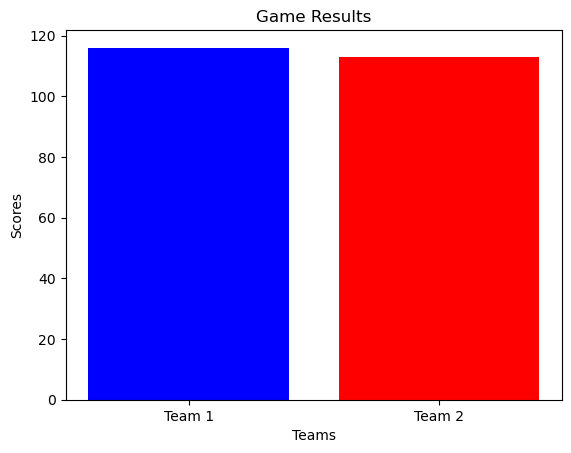

Player 1 Midrange and made Ast. Player 3
2-0
Player 8 Inside and made Ast. Player 7
2-2
Player 3 Midrange and made.
4-2
Player 8 3pt and made.
4-5
Player 1 Midrange and missed.
Player 6 Inside and missed.
Player 2 3pt and missed.
Player 7 Midrange and made Ast. Player 6
4-7
Player 1 Inside and missed.
Player 7 Inside and missed.
Player 4 Midrange and missed.
Player 10 3pt and missed.
Player 3 3pt and made.
7-7
Player 10 3pt and made Ast. Player 8
7-10
Player 5 Inside and missed.
Player 7 Midrange and made Ast. Player 6
7-12
Player 2 Inside and missed.
Player 7 3pt and made Ast. Player 6
7-15
Player 4 Midrange and made Ast. Player 1
9-15
Player 6 3pt and made.
9-18
Player 3 Midrange and made Ast. Player 2
11-18
Player 6 Midrange and made.
11-20
Player 2 Inside and made Ast. Player 3
13-20
Player 7 Midrange and made.
13-22
Player 2 Midrange and missed.
Player 9 Midrange and missed.
Player 2 3pt and missed.
Player 8 Midrange and missed.
Player 1 Inside and missed.
Player 8 Inside and miss

In [32]:
import matplotlib.pyplot as plt

def plot_game_results(team1_score, team2_score):
    labels = ['Team 1', 'Team 2']
    scores = [team1_score, team2_score]
    plt.bar(labels, scores, color=['blue', 'red'])
    plt.xlabel('Teams')
    plt.ylabel('Scores')
    plt.title('Game Results')
    plt.show()

def display_box_score(team):
    print(f"Box Score for {team.name}:")
    for player in team.players:
        print(f"{player.name} - Points: {player.points}, Assists: {player.assists}, "
              f"Shots Made: {player.shots_made}, Shots Attempted: {player.shots_attempted}")

# Example usage
team1_players = [
    Player('Player 1', 'PG', 80, 70, 90, 80, 85, 20),
    Player('Player 2', 'SG', 75, 65, 85, 75, 80, 30),
    Player('Player 3', 'SF', 78, 72, 88, 78, 82, 25),
    Player('Player 4', 'PF', 74, 68, 84, 76, 79, 15),
    Player('Player 5', 'C', 82, 75, 86, 79, 81, 10)
]

team2_players = [
    Player('Player 6', 'PG', 78, 72, 88, 78, 82, 25),
    Player('Player 7', 'SG', 74, 68, 84, 76, 79, 28),
    Player('Player 8', 'SF', 76, 71, 85, 77, 80, 22),
    Player('Player 9', 'PF', 73, 67, 83, 75, 78, 18),
    Player('Player 10', 'C', 81, 74, 87, 80, 83, 15)
]

team1 = Team('Team 1', team1_players)
team2 = Team('Team 2', team2_players)

team1_score, team2_score, play_by_play = simulate_game(team1, team2, 100)
plot_game_results(team1_score, team2_score)

# Display play-by-play
for play in play_by_play:
    print(play)

# Display box scores
display_box_score(team1)
display_box_score(team2)


In [34]:
pip install notebook


Note: you may need to restart the kernel to use updated packages.
